# Project Assignment A

## The idea
* Location: Afghanistan
* Aquired from: https://archive.org/details/WikileaksWarDiaryCsv (original link is dead: https://wikileaks.org/wiki/Afghan_War_Diary,_2004-2010)
* Time Span: 2004-2009
* Idea: Get an impression of who has been killed and wounded during the war and what were the main causes.
* Dataset: The secret dataset was leaked by the platform WikiLeaks in 2010 and contains every reported incident during the Afghanistan war: http://www.theguardian.com/world/2010/jul/25/afghanistan-war-logs-military-leaks. We also use GeoJSON data of Afghanistan for each district. The districts are splited in command centers for the NATO forces.

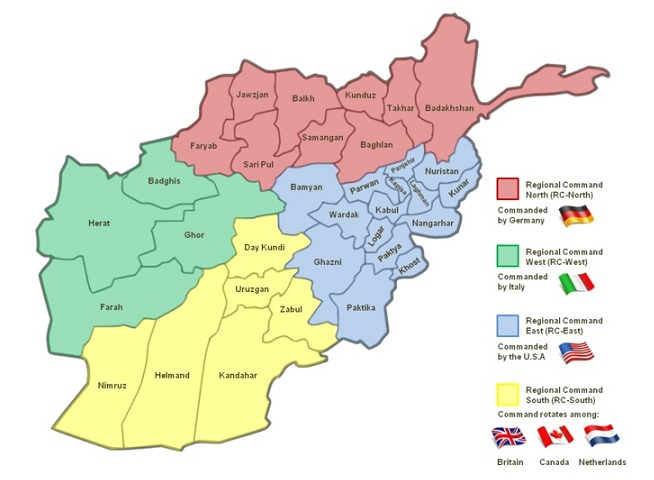

In [26]:
# Kabul is RC Capital
from IPython.display import Image
Image(filename='data/map.jpg')

* Why: The visualization of the war reveals the devastating loses of all included parties. During the war the visualization could have been used to identify common spots for enemy forces to attack or place traps.

## Loading and Cleaning the Data

Load WikiLeaks Afghan War Diary from 2004-2009.

In [27]:
# Pandas contains useful functions for data structures with "relational" or "labeled" data
import pandas

# header as suggested
# by WikiLeaks: https://wikileaks.org/afg/
# by the Guardian: http://www.theguardian.com/world/datablog/2010/jul/25/wikileaks-afghanistan-data
header = [
    'ReportKey', # find messages and also to reference them
    'DateOccurred', 'EventType', 
    'Category', # describes what kind of event the message is about
    'TrackingNumber', 'Title', # internal tracking number and title
    'Summary', # actual description of the event
    'Region', # broader region of the event, RC = regional command
    'AttackOn', # who was attacked during an event
    'ComplexAttack', #  signifies that an attack was a larger operation that required more planning, coordination and preparatio
    'ReportingUnit', 'UnitName', 'TypeOfUnit', # information on the military unit that authored the report
    'FriendlyWounded', 'FriendlyKilled', 'HostNationWounded', 'HostNationKilled', 'CivilianWounded', 'CivilianKilled', 
    'EnemyWounded', 'EnemyKilled', 'EnemyDetained', # who was killed/wounded/captured
    'MilitaryGridReferenceSystem', 'Latitude', 'Longitude', # location
    'OriginatorGroup', 'UpdatedByGroup', # message originated from or was updated by
    'CommandersCriticalInformationRequirements', 
    'Significant', # are analyzed and evaluated by special group in command centre
    'Affiliation', # event was of friendly, neutral or enemy nature
    'DisplayColor', # enemy activity - RED, friendly activity - BLUE, afghan/neutral activity (accidents, drugs etc.) - GREEN
    'ClassificationLevel' # classification level of the message, e.g.: Secret
]

data = pandas.read_csv('data/afg.csv', header=None, names=header)
# lower case some columns see problems: https://wardiaries.wikileaks.org/search/?sort=date
data['Category'] = data['Category'].str.lower()
data['Title'] = data['Title'].str.lower()
data.head()

ReportKey         DateOccurred  \
0  D92871CA-D217-4124-B8FB-89B9A2CFFCB4  2004-01-01 00:00:00   
1  C592135C-1BFF-4AEC-B469-0A495FDA78D9  2004-01-01 00:00:00   
2  D50F59F0-6F32-4E63-BC02-DB2B8422DE6E  2004-01-01 00:00:00   
3  E3F22EFB-F0CA-4821-9322-CC2250C05C8A  2004-01-01 00:00:00   
4  4D0E1E60-9535-4D58-A374-74367F058788  2004-01-01 00:00:00   

          EventType             Category        TrackingNumber  \
0      Enemy Action          direct fire  2007-033-004042-0756   
1   Friendly Action  cache found/cleared  2007-033-004738-0185   
2  Non-Combat Event           propaganda  2007-033-010818-0798   
3      Enemy Action          direct fire  2007-033-004042-0850   
4   Friendly Action  cache found/cleared  2007-033-004738-0279   

                        Title  \
0          direct fire  other   
1  cache found/cleared  other   
2           propaganda  other   
3          direct fire  other   
4  cache found/cleared  other   

                                             Summary    Region AttackOn  \
0  KAF-1BDE -S3 REPORTS: SUMMIT 09 B CO ELEMENT S...   RC EAST    ENEMY   
1  USSF FINDS CACHE IN VILLAGE OF WALU TANGAY: US...   RC EAST   FRIEND   
2  (M) NIGHT LETTERS DISTRIBUTED AROUND HAZARJUFT...  RC SOUTH  NEUTRAL   
3  KAF-1BDE -S3: SUMMIT 6 REPORTS TIC SALUTE TO F...   RC EAST    ENEMY   
4  KAF-1BDE -S3 REPORTS: GERONIMO 11 SALUTE AS FO...   RC EAST   FRIEND   

  ComplexAttack         ...          MilitaryGridReferenceSystem   Latitude  \
0         False         ...                      42SWB3900916257  32.683319   
1         False         ...                      42SXD7520076792  35.018608   
2         False         ...                      41RPQ1439743120  31.116390   
3         False         ...                      42SWB3399911991  32.645000   
4         False         ...                      42SWB7580277789  33.236389   

   Longitude  OriginatorGroup  UpdatedByGroup  \
0  69.416107          UNKNOWN         UNKNOWN   
1  70.920273          UNKNOWN         UNKNOWN   
2  64.199707          UNKNOWN         UNKNOWN   
3  69.362511          UNKNOWN         UNKNOWN   
4  69.813606          UNKNOWN         UNKNOWN   

   CommandersCriticalInformationRequirements  Significant  Affiliation  \
0                                        NaN          NaN        ENEMY   
1                                        NaN          NaN       FRIEND   
2                                        NaN          NaN      NEUTRAL   
3                                        NaN          NaN        ENEMY   
4                                        NaN          NaN       FRIEND   

   DisplayColor  ClassificationLevel  
0           RED               SECRET  
1          BLUE               SECRET  
2         GREEN               SECRET  
3           RED               SECRET  
4          BLUE               SECRET  

[5 rows x 32 columns]

Extract a glossary of military terms from the Guardian: http://www.theguardian.com/world/datablog/2010/jul/25/wikileaks-afghanistan-war-logs-glossary

In [28]:
# generate the glossary
import bs4, lxml, re, requests

link = 'http://www.theguardian.com/world/datablog/2010/jul/25/wikileaks-afghanistan-war-logs-glossary'
response = requests.get(link)
try:
    if not response.ok:
        print 'HTTP error {} trying to fetch Guradian glossary: {}'.format(response.status_code, link)
    else:
        glossary = dict()
        soup = bs4.BeautifulSoup(response.content, 'lxml')
        glossary_table = soup.find('table')
        for row in glossary_table.find_all('tr'):
                cells = row.find_all("td")
                if len(cells) == 2:
                    if cells[0].string:
                        key = str(cells[0].string.strip().lower())
                        content = cells[1].text
                        glossary[key] = content
except requests.exceptions.ConnectionError as e:
    'Connection error {} on {}'.format(e, link)

print glossary['afg']

Afghans 


## Exploratory analysis
Some common information about the dataset

In [29]:
data['DateOccurred'] = pandas.to_datetime(data['DateOccurred'])
data['Year'] = [date.year for date in data['DateOccurred']]
data['Hour'] = [date.hour for date in data['DateOccurred']]

#Number of rows/columns
print "Number of rows: %d" % data.shape[0]
print "Number of columns: %d" % data.shape[1]

date_range = set()
for date in data['DateOccurred']:
    date_range.add(date.year)

print "\nYears:\n"
print list(date_range)

#Ocurrences of categories
print "\nNumber of unique categories: %d" %len(set(data['Category']))

#Distribution of categoriesn_occurrences[0:20]
n_occurrences = data['Category'].value_counts()

print "\nMost commonly occurring categories of crime:\n"
print n_occurrences.head()

print "\nMost commonly occurring category of crime is %s with %d" % (n_occurrences.argmax(), n_occurrences.max())
print "\nLeast commonly occurring category of crime is %s with %d" % (n_occurrences.argmin(), n_occurrences.min())

Number of rows: 76911
Number of columns: 34

Years:

[2004, 2005, 2006, 2007, 2008, 2009]

Number of unique categories: 153

Most commonly occurring categories of crime:

direct fire          16293
ied found/cleared     8581
indirect fire         7237
ied explosion         7202
other                 4693
Name: Category, dtype: int64

Most commonly occurring category of crime is direct fire with 16293

Least commonly occurring category of crime is graffiti with 1


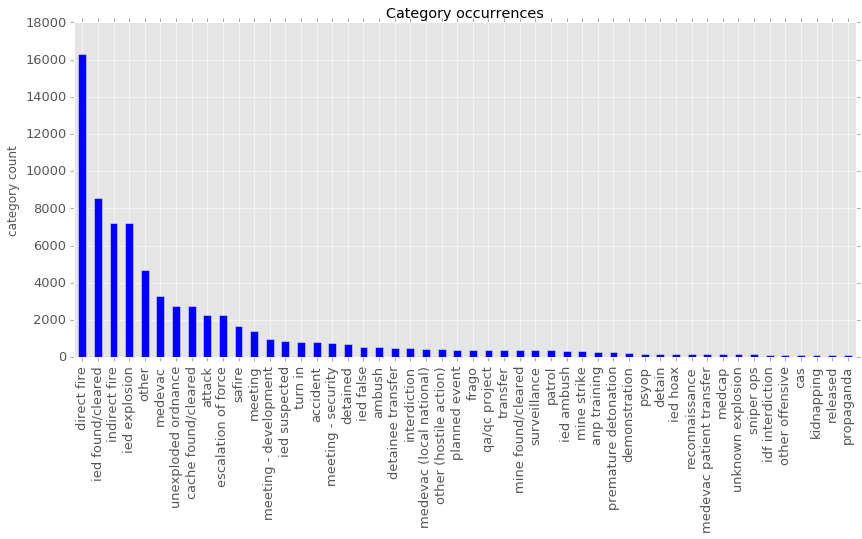

In [30]:
# plot distribution of categories (TOP 50)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

n_occurrences_top = n_occurrences[0:50]

#plot histogram
def barplot(series, title, figsize, ylabel, flag, rotation):
    #plot hist
    ax = series.plot(kind='bar', 
                title = title,
                figsize = figsize,
                fontsize = 13)
    
    # set ylabel
    ax.set_ylabel(ylabel)
    # set xlabel (depending on the flag that comes as a function parameter)
    ax.get_xaxis().set_visible(flag)
    # set series index as xlabels and rotate them
    ax.set_xticklabels(series.index, rotation= rotation)
    
barplot(n_occurrences_top,'Category occurrences', figsize=(14,6), ylabel = 'category count',flag = True, rotation = 90)

In [31]:
focus_categories = n_occurrences.index[0:8]
print focus_categories

Index([u'direct fire', u'ied found/cleared', u'indirect fire',
       u'ied explosion', u'other', u'medevac', u'unexploded ordnance',
       u'cache found/cleared'],
      dtype='object')


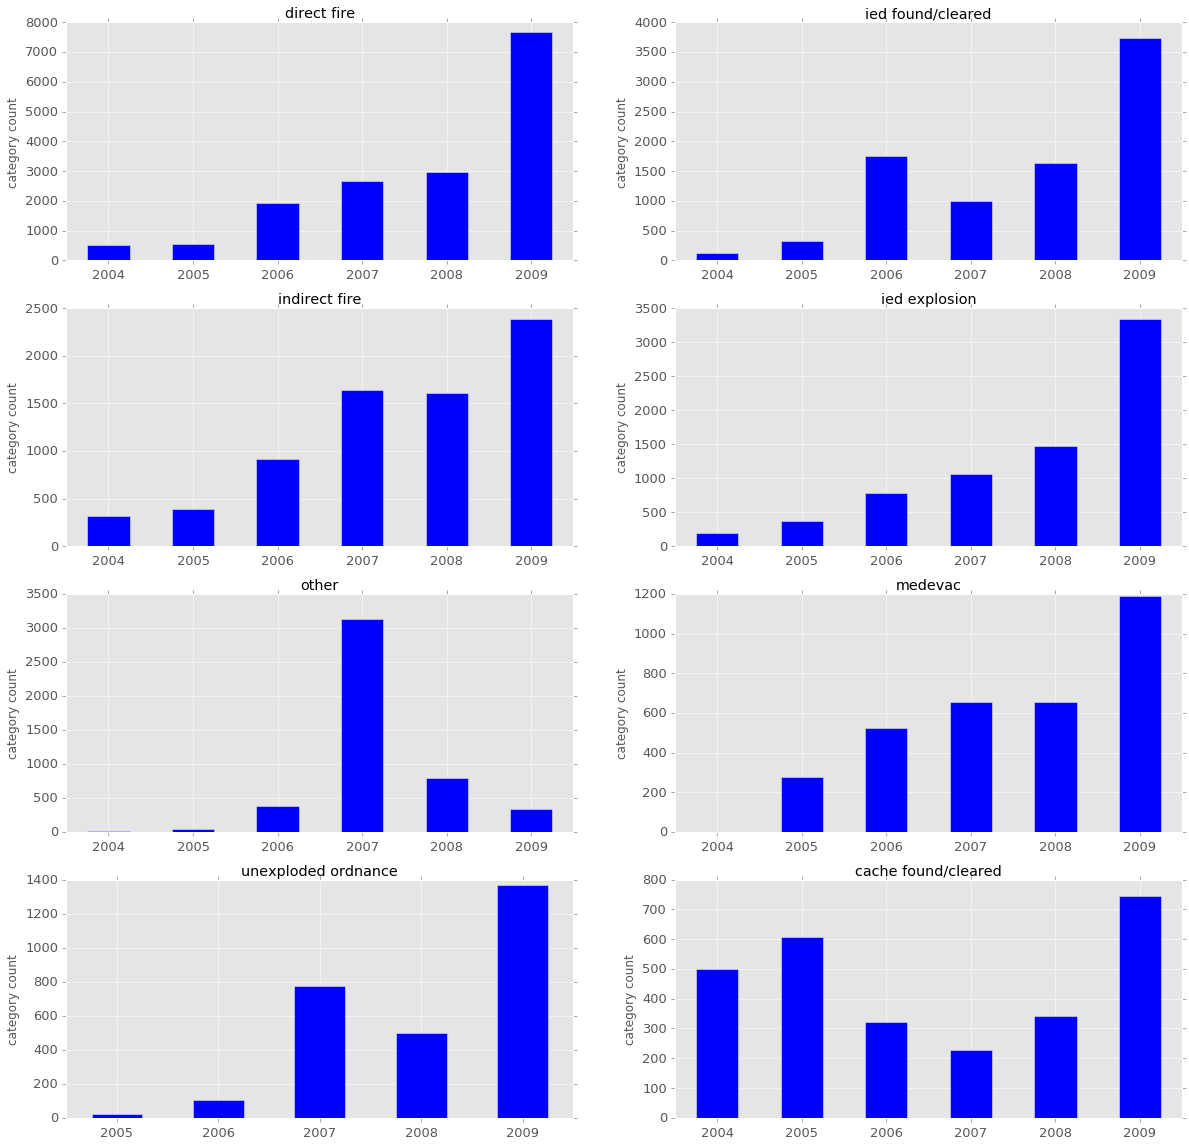

In [32]:
def yearly_category_distribution(data, focus_categories):
    
    index = 1
    for category in focus_categories:
        #filter table by type of category
        db = data[data['Category'] == category]
        #get year counts of that crime
        year_counts = db['Year'].value_counts()
        #sort it (from 2004 to 2009)
        year_counts = year_counts.sort_index()
        #plot it
        plt.subplot(7,2,index)
        barplot(year_counts, category, figsize=(20,35), ylabel = 'category count', flag = True, rotation = 0)
        index += 1
        
yearly_category_distribution(data, focus_categories)

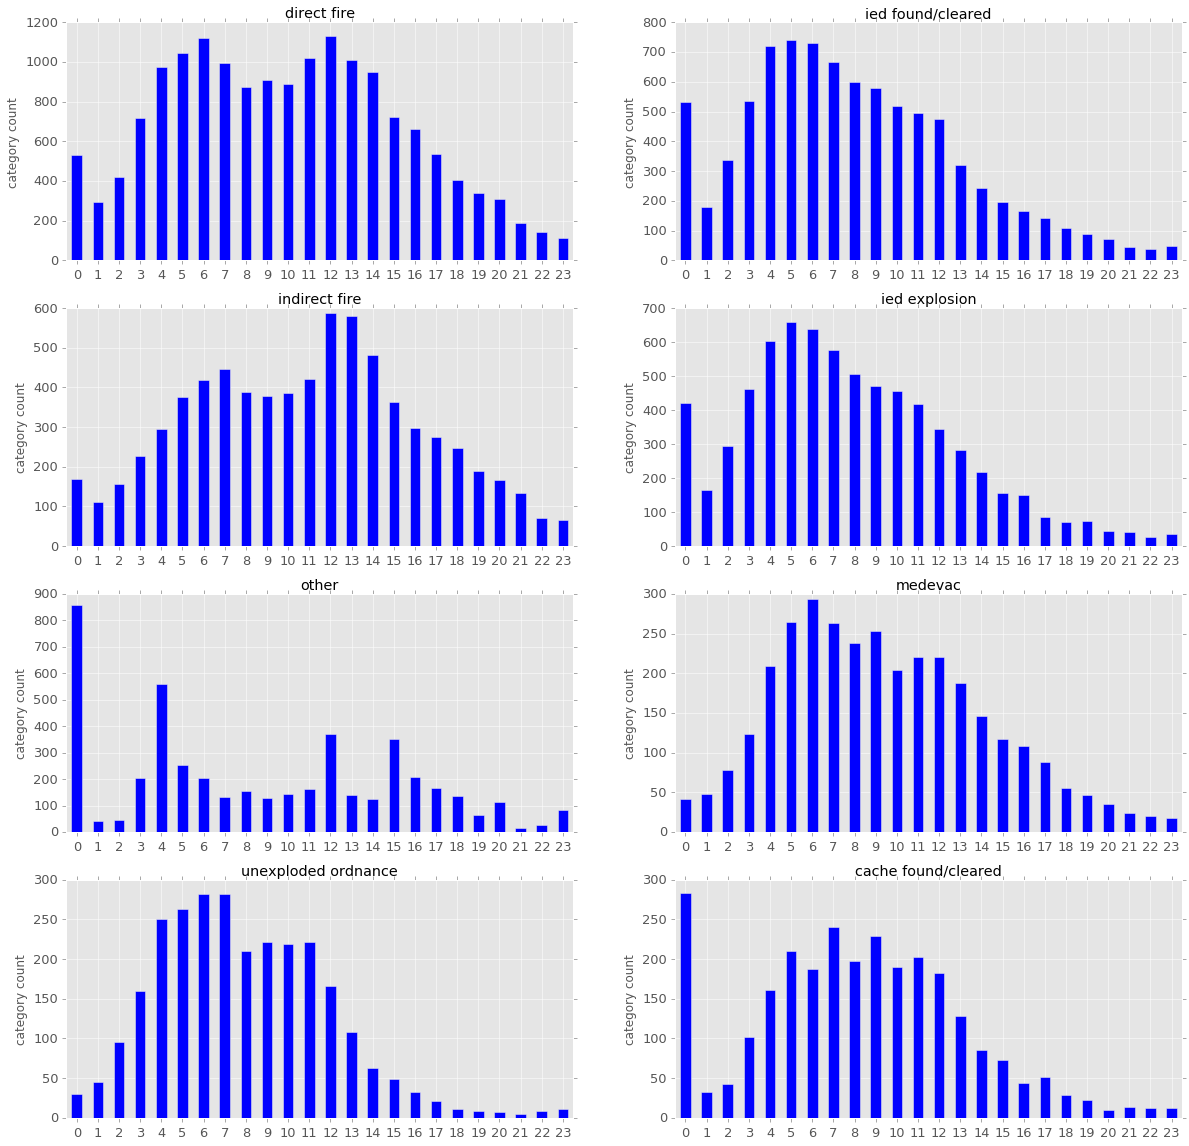

In [33]:
def hourly_category_distribution(data, focus_categories):
    
    index = 1
    for category in focus_categories:
        #filter table by type of category
        db = data[data['Category'] == category]
        #get year counts of that crime
        hour_counts = db['Hour'].value_counts()
        #sort it (from 2004 to 2009)
        hour_counts = hour_counts.sort_index()
        #plot it
        plt.subplot(7,2,index)
        barplot(hour_counts, category, figsize=(20,35), ylabel = 'category count', flag = True, rotation = 0)
        index += 1
        
hourly_category_distribution(data, focus_categories)

## Visualization possibilities

Casualties and wounded recorded per year. A bar plot with one bar for each of the categories:
* Enemy .. Taliban
* HostNation .. Afghan soliders
* Friendly .. NATO forces
* Civilians .. Afghan population

(MACHINE LEARNING: KNN)
> One Map of Afghanistan with incidents (color scheme DisplayColor: enemy activity - RED, friendly activity - BLUE, friend on friend - GREEN).

(MACHINE LEARNING: Cluster K-Means)
> Map with 5 regions and choose one category and cluster all incidents during the war, see how many died at specific incident.

(MACHINE LEARNING: Decision Tree/Random Forest)
> x-axis: morning=6-10, midday=11-14, afternoon=15-17, evening=18-23
> y-axis: prediction score of each category in scatterplot, bubble size according to all incidents in that area 

EXTRA: 
> Word clouds for categories or summary.

An example of all enemy attacks below.

In [34]:
import geoplotlib
from geoplotlib.utils import BoundingBox

def geo_plot(geodata):
    """
    Plot given coordinate input
    """

    # bounding box on the minima and maxima of the data
    geoplotlib.set_bbox(
        BoundingBox(
            max(geodata['lat']), 
            max(geodata['lon']), 
            min(geodata['lat']), 
            min(geodata['lon'])
        ));
    
    # kernel density estimation visualization
    geoplotlib.kde(geodata, bw=5, cut_below=1e-3, cmap='hot', alpha=170)
    # google tiles with lyrs=y ... hybrid
    geoplotlib.tiles_provider({
        'url': lambda zoom, xtile, ytile: 'https://mt1.google.com/vt/lyrs=y&hl=en&x=%d&y=%d&z=%d' % (xtile, ytile, zoom ),
        'tiles_dir': 'DTU-social_data',
        'attribution': 'DTU 02806 Social Data Analysis and Visualization'
    })
    
# only enemy activity
include = (data.Latitude < 38) & (data.Latitude > 30) & (data.Longitude > 55) &(data.Longitude < 75) & (data.DisplayColor == 'RED')

# index geodata
geodata = {
    "lat": data.loc[include].Latitude.tolist(), 
    "lon": data.loc[include].Longitude.tolist()
}

geo_plot(geodata)
geoplotlib.inline();

('smallest non-zero count', 7.1647865443840454e-10)
('max count:', 9.6873684303468082)


In [35]:
print len(data[data.ClassificationLevel.isin(['secret'])])

0
